<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/6zMixedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset


In [32]:
import pandas as pd
df=pd.read_csv("Houses-dataset/Houses Dataset/HousesInfo.txt",header=None,delim_whitespace=True,
               names=["bedrooms","bathrooms","size","zipcode","price"])

In [ ]:
df[0:10]

count the number of houses per zipcode

In [33]:
zipcodes=df['zipcode'].value_counts().keys().tolist()
counts=df['zipcode'].value_counts().tolist()

remove all the entries with zipcodes containing less than 20 houses

In [34]:
for count,zipcode in zip(counts,zipcodes):
  if count<20:
    idx=df[df['zipcode']==zipcode].index
    df.drop(idx,inplace=True)

In [ ]:
df[0:10]

In [35]:
import cv2

image_list=[]
prefix="Houses-dataset/Houses Dataset/"
suffix="_frontal.jpg"
for idx in df.index.tolist():
  path=prefix+str(idx)+suffix
  img=cv2.imread(path)
  img=cv2.resize(img,(48,48))
  image_list.append(img)

In [36]:

import numpy as np
images=np.stack(image_list)

In [ ]:
images.shape

In [37]:
images=images/255.

In [38]:
values=df.values
prices=values[:,4]
max_price=prices.max()
prices=prices/max_price

bedrooms=values[:,0]
bathrooms=values[:,1]
size=values[:,2]
max_size=size.max()
size=size/max_size
zipcodes=values[:,3]
max_zipcodes=zipcodes.max()
zipcodes=tf.one_hot(zipcodes,max_zipcodes).numpy()

In [39]:
#features=np.hstack([bedrooms,bathrooms,size,zipcodes])
nsamples=384
bathrooms=bathrooms.reshape(nsamples,1)
bedrooms=bedrooms.reshape(nsamples,1)
size=size.reshape(nsamples,1)
print(bathrooms.shape)
print(bedrooms.shape)
print(size.shape)
#print(zipcodes.shape)
features=np.hstack([bedrooms,bathrooms,size,zipcodes])
#features=np.hstack([bedrooms,bathrooms,size])
features.shape

(384, 1)
(384, 1)
(384, 1)


(384, 94534)

In [40]:
train_images=images[0:300]
test_images=images[300:nsamples]
train_features=features[0:300]
test_features=features[300:nsamples]
train_prices=prices[0:300]
test_prices=prices[300:nsamples]
#max_price=train_prices.max()
#train_prices=train_prices/max_price
#test_prices=test_prices/max_price

In [41]:
from tensorflow.keras.layers import Dense,Input,concatenate,Flatten
from tensorflow.keras.models import Model


In [42]:
def get_features_modelA():
  features_input=Input(shape=(4,),name="features_input")
  features_layers=Dense(64,activation="relu")(features_input)
  features_layers=Dense(32,activation="relu")(features_layers)
  features_layers=Dense(16,activation="relu")(features_layers)
  features_output=Dense(1,activation="linear")(features_layers)
  model=Model(inputs=features_input,outputs=features_output)
  return model
def get_features_modelB():
  features_input=Input(shape=(train_features.shape[1]),name="features_input")
  features_layers=Dense(32,activation="relu")(features_input)
  features_layers=Dense(16,activation="relu")(features_layers)
  features_output=Dense(1,activation="linear")(features_layers)
  model=Model(inputs=features_input,outputs=features_output)
  return model


In [ ]:
def get_image_model():
  image_input=Input(shape=(48,48,3),name="image_input")
  flatten=Flatten()(image_input)
  image_layers=Dense(64,activation="relu")(flatten)
  image_output=Dense(1,activation="linear")(image_layers)
  image_model=Model(inputs=image_input,outputs=image_output)
  return image_model

In [43]:
features_model=get_features_modelB()

In [ ]:
image_model=get_image_model()
both=concatenate([image_model.output,features_model.output])
both=Dense(10,activation='relu')(both)
both=Dense(1,activation='linear')(both)
model=Model(inputs=[features_model.input,image_model.input],outputs=both)


In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
opt=tf.keras.optimizers.RMSprop(lr=1e-3)
model.compile(optimizer=opt,loss='mean_absolute_percentage_error')


In [ ]:
model.fit(x=[train_features,train_images],y=train_prices,epochs=1000)


In [44]:
opt=tf.keras.optimizers.Adam()
features_model.compile(optimizer="Adam",loss="mean_absolute_percentage_error")

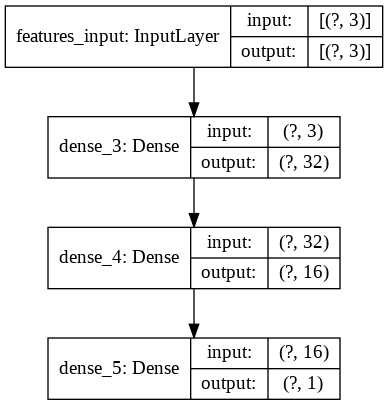

In [24]:
tf.keras.utils.plot_model(features_model,show_shapes=True)

In [45]:
features_model.fit(x=train_features,y=train_prices,batch_size=16,epochs=200)

Epoch 1/200
19/19 [==============================] - 0s 18ms/step - loss: 64.7363
Epoch 2/200
19/19 [==============================] - 0s 18ms/step - loss: 33.2338
Epoch 3/200
19/19 [==============================] - 0s 20ms/step - loss: 34.3247
Epoch 4/200
19/19 [==============================] - 0s 18ms/step - loss: 26.6135
Epoch 5/200
19/19 [==============================] - 0s 18ms/step - loss: 29.6375
Epoch 6/200
19/19 [==============================] - 0s 18ms/step - loss: 24.6579
Epoch 7/200
19/19 [==============================] - 0s 18ms/step - loss: 25.5125
Epoch 8/200
19/19 [==============================] - 0s 19ms/step - loss: 24.5565
Epoch 9/200
19/19 [==============================] - 0s 18ms/step - loss: 24.9769
Epoch 10/200
19/19 [==============================] - 0s 18ms/step - loss: 24.1702
Epoch 11/200
19/19 [==============================] - 0s 19ms/step - loss: 23.9029
Epoch 12/200
19/19 [==============================] - 0s 18ms/step - loss: 24.4159
Epoch 13/200


In [ ]:
model.evaluate([test_features,test_images],test_prices)


In [46]:
features_model.evaluate(test_features,test_prices)

3/3 [==============================] - 0s 5ms/step - loss: 32.5249


32.524925231933594

In [ ]:
combined_predict=np.squeeze(model.predict([test_features[0:10],test_images[0:10]]))


In [47]:
features_predict=np.squeeze(features_model.predict(test_features[0:10]))
features_predict.shape

(10,)

In [48]:
print(np.abs(test_prices[0:10]-features_predict)/test_prices[0:10])


[0.05278161 0.01053283 0.11336104 0.09382799 0.22384661 0.0412547
 0.39982207 0.3108411  0.06694703 0.36479868]


In [ ]:
print(np.abs(test_prices[0:10]-combined_predict)/test_prices[0:10])